In [22]:
import pandas as pd
import numpy as np
import os
import asgl
from pathlib import Path
from sklearn import clone

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, LassoCV, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.svm import l1_min_c
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import spearmanr

from stabl.pipelines_utils import compute_scores_table, save_plots
from stabl.preprocessing import LowInfoFilter
from stabl.metrics import jaccard_matrix

from stabl.stacked_generalization import stacked_multi_omic
import random

lasso_cv = LassoCV(alphas=[10.**i for i in np.arange(-3, 1.1, 0.05)], max_iter=int(1e6), n_jobs=-1)

linreg = LinearRegression()
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

preprocessing = Pipeline(
    steps=[
        ("variance", VarianceThreshold(0.)),
        ("lif", LowInfoFilter()),
        ("impute", SimpleImputer(strategy="median")),
        ("std", StandardScaler())
    ]
)

In [23]:
mode = "" # "term vs preterm" or ""

## Import Data

In [24]:
#Import Data
X_ga = pd.read_csv('./Data/All/GA.csv',index_col=0)
X_cytof = pd.read_csv('./Data/All/Cytof.csv',index_col=0)
X_prot = pd.read_csv('./Data/All/Proteomics.csv',index_col=0)

X_ga_term = pd.read_csv('./Data/Term/GA.csv',index_col=0)
X_cytof_term = pd.read_csv('./Data/Term/Cytof.csv',index_col=0)
X_prot_term = pd.read_csv('./Data/Term/Proteomics.csv',index_col=0)

X_ga_preterm = pd.read_csv('./Data/Preterm/GA.csv',index_col=0)
X_cytof_preterm = pd.read_csv('./Data/Preterm/Cytof.csv',index_col=0)
X_prot_preterm = pd.read_csv('./Data/Preterm/Proteomics.csv',index_col=0)

if mode == "term vs preterm":
	train_data_dict = {
		'CYTOF': X_cytof_term,
		'GA': X_ga_term,
		'Proteomics': X_prot_term
	}

	test_data_dict = {
		'CYTOF': X_cytof_preterm,
		'GA': X_ga_preterm,
		'Proteomics': X_prot_preterm
	}

	y_train = pd.read_csv('./Data/Term/DOS.csv',index_col=0).iloc[:,0]
	y_test = pd.read_csv('./Data/Preterm/DOS.csv',index_col=0).iloc[:,0]
else:
	train_data_dict = {
		'CYTOF': X_cytof,
		'GA': X_ga,
		'Proteomics': X_prot
	}

	y = pd.read_csv('./Data/All/DOS.csv',index_col=0)

	train_idx, test_idx = train_test_split(X_ga.index, test_size=0.2, random_state=42)

	y_train = y.loc[train_idx].iloc[:,0]
	y_test = y.loc[test_idx].iloc[:,0]

In [25]:
result_path = "./Results"
try:
    os.mkdir(result_path)
except FileExistsError:
    pass

## EF

In [27]:
if mode == "term vs preterm":
    ef_path = result_path + '/EF ' + mode
else:
    ef_path = result_path + '/EF'
    
try:
    os.mkdir(ef_path)
except FileExistsError:
    pass

In [28]:
X = pd.concat(train_data_dict.values(), axis=1)

if mode == "term vs preterm":
    X_val = pd.concat(test_data_dict.values(), axis=1)
    X_trains = {"GA" : X, "noGA" : X.drop("GA", axis=1)}
    X_tests = {"GA" : X_val, "noGA" : X_val.drop("GA", axis=1)}
else:
    X_trains = {"GA" : X.loc[train_idx], "noGA" : X.loc[train_idx].drop("GA", axis=1)}
    X_tests = {"GA" : X.loc[test_idx], "noGA" : X.loc[test_idx].drop("GA", axis=1)}

X_trains["GA"] = pd.DataFrame(
            data=preprocessing.fit_transform(X_trains["GA"]),
            columns=preprocessing.get_feature_names_out(),
            index=X_trains["GA"].index
        )

X_tests["GA"] = pd.DataFrame(
            data=preprocessing.transform(X_tests["GA"]),
            columns=preprocessing.get_feature_names_out(),
            index=X_tests["GA"].index
        )

X_trains["noGA"] = pd.DataFrame(
            data=preprocessing.fit_transform(X_trains["noGA"]),
            columns=preprocessing.get_feature_names_out(),
            index=X_trains["noGA"].index
        )

X_tests["noGA"] = pd.DataFrame(
            data=preprocessing.transform(X_tests["noGA"]),
            columns=preprocessing.get_feature_names_out(),
            index=X_tests["noGA"].index
        )

In [29]:
fit_lassos = dict()
fit_lassos["GA"] = clone(lasso_cv).fit(X_trains["GA"], y_train)
fit_lassos["noGA"] = clone(lasso_cv).fit(X_trains["noGA"], y_train)

/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_33868/664871770.py:66: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_33868/664871770.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_33868/664871770.py:66: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


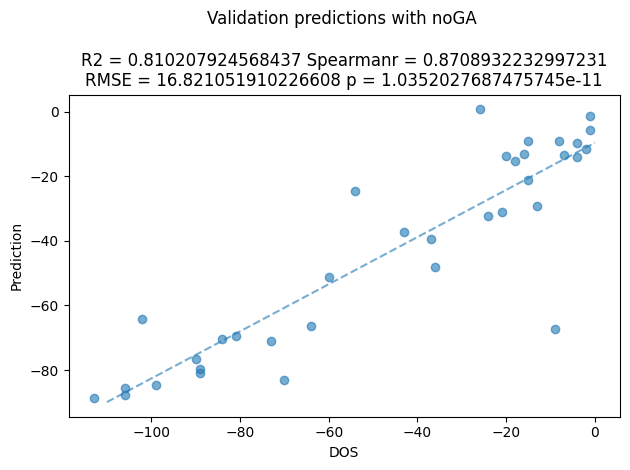

In [30]:
import matplotlib.pyplot as plt

for config, fit_lasso in fit_lassos.items():
    # Plotting optimization paths
    plt.clf()
    plt.plot(fit_lasso.alphas_, np.min(fit_lasso.mse_path_, axis=1), label="min cv_mse")
    plt.plot(fit_lasso.alphas_, np.max(fit_lasso.mse_path_, axis=1), label="max cv_mse")
    plt.plot(fit_lasso.alphas_, np.mean(fit_lasso.mse_path_, axis=1), label="mean cv_mse")
    plt.plot([fit_lasso.alpha_]*len(np.arange(0., np.max(np.max(fit_lasso.mse_path_, axis=1)), 10)),
            np.arange(0., np.max(np.max(fit_lasso.mse_path_, axis=1)), 10), label = "Optimal \u03BB",  color='red', linestyle='--')
    plt.xscale('log')
    plt.xlabel("\u03BB")
    plt.ylabel('MSE')
    plt.title("\u03BB optimization")
    plt.legend()
    
    # Saving optimization path
    plt.savefig(Path(ef_path, f"Lasso optimization path with {config}.png"))
    
    # Getting the coefficients of the model
    coefs = pd.DataFrame({"feature": fit_lasso.feature_names_in_, "coefficient" : fit_lasso.coef_}).set_index("feature").sort_values(by='coefficient', ascending=False)
    selected_features = coefs[coefs["coefficient"] !=0]

    # Saving coefficients and selected features
    coefs.to_csv(Path(ef_path, f"Lasso coefficients with {config}.csv"))
    selected_features.to_csv(Path(ef_path, f"Lasso selected features with {config}.csv"))
    
    # Training predictions plot
    ## Scores
    y_preds = fit_lasso.predict(X_trains[config])
    lin_reg = clone(linreg).fit(np.array(y_train).reshape(-1, 1), np.array(y_preds).reshape(-1, 1))
    y_reg = lin_reg.intercept_ + lin_reg.coef_[0]*y_train
    r2 = r2_score(y_preds, y_reg)
    correlation, p_value = spearmanr(y_preds, y_train)
    rmse = np.sqrt(mean_squared_error(y_preds, y_train))

    ## Plot
    plt.clf()
    plt.scatter(y_train, y_preds, alpha=0.6)
    plt.plot(np.arange(-110, 1, 1), lin_reg.intercept_ + lin_reg.coef_[0]*np.arange(-110, 1, 1), color='C0', alpha=0.6, linestyle='--')
    plt.xlabel("DOS")
    plt.ylabel("Prediction")
    plt.title(f"Training predictions with {config} \n\nR2 = {r2} Spearmanr = {correlation}\nRMSE = {rmse} p = {p_value}")
    plt.tight_layout()
    
    ## Saving plot
    plt.savefig(Path(ef_path, f"Lasso training predictions with {config}.png"))

    # Test predictions plot
    ## Scores
    y_preds = fit_lasso.predict(X_tests[config])
    lin_reg = clone(linreg).fit(np.array(y_test).reshape(-1, 1), np.array(y_preds).reshape(-1, 1))
    y_reg = lin_reg.intercept_ + lin_reg.coef_[0]*y_test
    r2 = r2_score(y_preds, y_reg)
    correlation, p_value = spearmanr(y_preds, y_test)
    rmse = np.sqrt(mean_squared_error(y_preds, y_test))

    ## Plot
    plt.clf()
    plt.scatter(y_test, y_preds, alpha=0.6)
    plt.plot(np.arange(-110, 1, 1), lin_reg.intercept_ + lin_reg.coef_[0]*np.arange(-110, 1, 1), color='C0', alpha=0.6, linestyle='--')
    #plt.plot(np.arange(-110, 1, 1), np.arange(-110, 1, 1), color='red', linestyle='--')
    plt.xlabel("DOS")
    plt.ylabel("Prediction")
    plt.title(f"Validation predictions with {config} \n\nR2 = {r2} Spearmanr = {correlation}\nRMSE = {rmse} p = {p_value}")
    plt.tight_layout()
    
    ## Saving plot
    plt.savefig(Path(ef_path, f"Lasso validation predictions with {config}.png"))

## LF

In [31]:
if mode == "term vs preterm":
    lf_path = result_path + '/LF ' + mode
else:
    lf_path = result_path + '/LF'

try:
    os.mkdir(lf_path)
except FileExistsError:
    pass

In [32]:
if mode == "term vs preterm":
    X_trains = train_data_dict
    X_tests = test_data_dict
else:
    X_trains = {
        'CYTOF': X_cytof.loc[train_idx],
        'GA': X_ga.loc[train_idx],
        'Proteomics': X_prot.loc[train_idx]
    }

    X_tests = {
        'CYTOF': X_cytof.loc[test_idx],
        'GA': X_ga.loc[test_idx],
        'Proteomics': X_prot.loc[test_idx]
    }

for omic_name in X_trains.keys():
    X_trains[omic_name] = pd.DataFrame(
            data=preprocessing.fit_transform(X_trains[omic_name]),
            columns=preprocessing.get_feature_names_out(),
            index=X_trains["GA"].index
        )
    X_tests[omic_name] = pd.DataFrame(
            data=preprocessing.transform(X_tests[omic_name]),
            columns=preprocessing.get_feature_names_out(),
            index=X_tests[omic_name].index
        )

/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_33868/3880886854.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_33868/3880886854.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_33868/3880886854.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_33868/3880886854.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_33868/3880886854.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


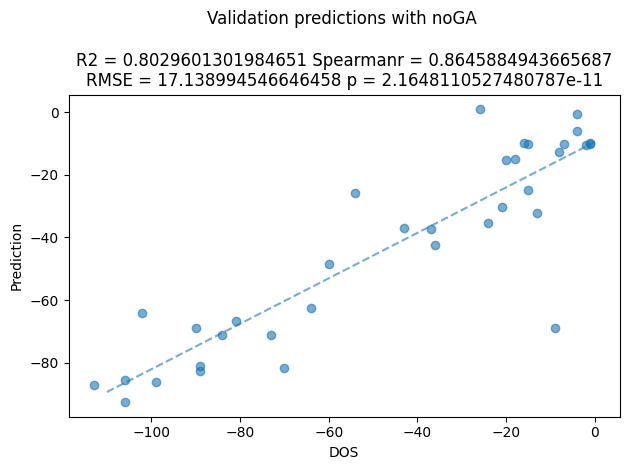

In [33]:
# Building lassos on each omic
for omic_name, X_train in X_trains.items():
    # Creating a new folder
    omic_path = lf_path + '/' + omic_name
    try:
        os.mkdir(omic_path)
    except FileExistsError:
        pass
    
    # Building a Lasso
    fit_lasso = clone(lasso_cv).fit(X_train, y_train)
    
    # Plotting optimization paths
    plt.clf()
    plt.plot(fit_lasso.alphas_, np.min(fit_lasso.mse_path_, axis=1), label="min cv_mse")
    plt.plot(fit_lasso.alphas_, np.max(fit_lasso.mse_path_, axis=1), label="max cv_mse")
    plt.plot(fit_lasso.alphas_, np.mean(fit_lasso.mse_path_, axis=1), label="mean cv_mse")
    plt.plot([fit_lasso.alpha_]*len(np.arange(0., np.max(np.max(fit_lasso.mse_path_, axis=1)), 10)),
            np.arange(0., np.max(np.max(fit_lasso.mse_path_, axis=1)), 10), label = "Optimal \u03BB",  color='red', linestyle='--')
    plt.xscale('log')
    plt.xlabel("\u03BB")
    plt.ylabel('MSE')
    plt.title("\u03BB optimization")
    plt.legend()
    
    # Saving optimization path
    plt.savefig(Path(omic_path, f"Lasso optimization path for {omic_name}.png"))
    
    # Getting the coefficients of the model
    coefs = pd.DataFrame({"feature": fit_lasso.feature_names_in_, "coefficient" : fit_lasso.coef_}).set_index("feature").sort_values(by='coefficient', ascending=False)
    selected_features = coefs[coefs["coefficient"] !=0]

    # Saving coefficients and selected features
    coefs.to_csv(Path(omic_path, f"Lasso coefficients for {omic_name}.csv"))
    selected_features.to_csv(Path(omic_path, f"Lasso selected features for {omic_name}.csv"))
    
    # Training predictions plot
    ## Scores
    y_preds = fit_lasso.predict(X_train)
    lin_reg = clone(linreg).fit(np.array(y_train).reshape(-1, 1), np.array(y_preds).reshape(-1, 1))
    y_reg = lin_reg.intercept_ + lin_reg.coef_[0]*y_train
    r2 = r2_score(y_preds, y_reg)
    correlation, p_value = spearmanr(y_preds, y_train)
    rmse = np.sqrt(mean_squared_error(y_preds, y_train))

    ## Plot
    plt.clf()
    plt.scatter(y_train, y_preds, alpha=0.6)
    plt.plot(np.arange(-110, 1, 1), lin_reg.intercept_ + lin_reg.coef_[0]*np.arange(-110, 1, 1), color='C0', alpha=0.6, linestyle='--')
    #plt.plot(np.arange(-110, 1, 1), np.arange(-110, 1, 1), color='red', linestyle='--')
    plt.xlabel("DOS")
    plt.ylabel("Prediction")
    plt.title(f"Training predictions for {omic_name} \n\nR2 = {r2} Spearmanr = {correlation}\nRMSE = {rmse} p = {p_value}")
    plt.tight_layout()
    
    ## Saving plot and preds
    plt.savefig(Path(omic_path, f"Lasso training predictions for {omic_name}.png"))
    pd.DataFrame({"ID":X_train.index, "pred":y_preds}).set_index("ID").to_csv(Path(omic_path, f"Lasso training predictions for {omic_name}.csv"))

    # Test predictions plot
    ## Scores
    y_preds = fit_lasso.predict(X_tests[omic_name])
    lin_reg = clone(linreg).fit(np.array(y_test).reshape(-1, 1), np.array(y_preds).reshape(-1, 1))
    y_reg = lin_reg.intercept_ + lin_reg.coef_[0]*y_test
    r2 = r2_score(y_preds, y_reg)
    correlation, p_value = spearmanr(y_preds, y_test)
    rmse = np.sqrt(mean_squared_error(y_preds, y_test))

    ## Plot
    plt.clf()
    plt.scatter(y_test, y_preds, alpha=0.6)
    plt.plot(np.arange(-110, 1, 1), lin_reg.intercept_ + lin_reg.coef_[0]*np.arange(-110, 1, 1), color='C0', alpha=0.6, linestyle='--')
    #plt.plot(np.arange(-110, 1, 1), np.arange(-110, 1, 1), color='red', linestyle='--')
    plt.xlabel("DOS")
    plt.ylabel("Prediction")
    plt.title(f"Validation predictions with {config} \n\nR2 = {r2} Spearmanr = {correlation}\nRMSE = {rmse} p = {p_value}")
    plt.tight_layout()
    
    ## Saving plot 
    plt.savefig(Path(omic_path, f"Lasso validation predictions for {omic_name}.png"))
    pd.DataFrame({"ID":X_tests[omic_name].index, "pred":y_preds}).set_index("ID").to_csv(Path(omic_path, f"Lasso validation predictions for {omic_name}.csv"))
    

/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_33868/826299525.py:79: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_33868/826299525.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_33868/826299525.py:79: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


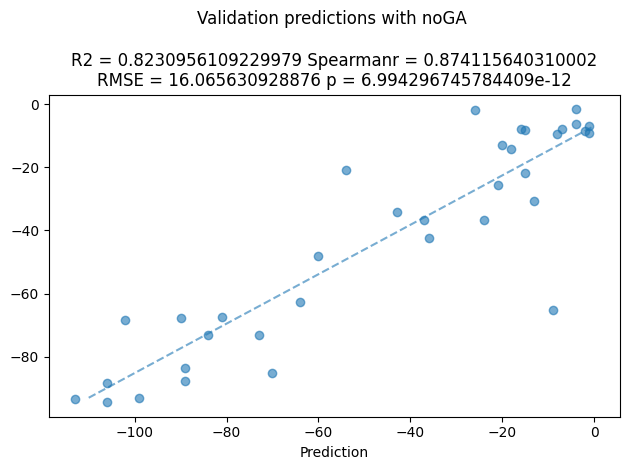

In [35]:
# Stack generalization

for config in ["GA", "noGA"]:
    # Creating a new folder
    stack_path = lf_path + '/Stack generalized with ' + config
    try:
        os.mkdir(stack_path)
    except FileExistsError:
        pass
    
    # Concatenating the predictions from the 2 or 3 omics
    if config == "GA":
        omic_names = ["CYTOF", "Proteomics", "GA"]
    elif config == "noGA":
        omic_names = ["CYTOF", "Proteomics"]
    else:
        print(config + ' NOT RECOGNIZED')
    
    prediction_dict = dict()
    for omic_name in omic_names:
        prediction_dict[omic_name] = pd.read_csv(Path(lf_path, omic_name, f"Lasso training predictions for {omic_name}.csv"), index_col=0).rename(columns={'pred': omic_name})
    prediction_df = pd.concat(prediction_dict.values(), axis=1)
    
    # Building a linear regression
    stack_model = clone(rf_regressor).fit(prediction_df, y_train)
    
    # Getting the importance of the features
    imp = pd.DataFrame({"omic": stack_model.feature_names_in_, "importance" : stack_model.feature_importances_}).set_index("omic").sort_values(by='importance', ascending=False)

    # Saving importance of features
    imp.to_csv(Path(stack_path, f"Stack model feature importance with {config}.csv"))
    
    # Training predictions plot
    ## Scores
    y_preds = stack_model.predict(prediction_df)
    lin_reg = clone(linreg).fit(np.array(y_train).reshape(-1, 1), np.array(y_preds).reshape(-1, 1))
    y_reg = lin_reg.intercept_ + lin_reg.coef_[0]*y_train
    r2 = r2_score(y_preds, y_reg)
    correlation, p_value = spearmanr(y_preds, y_train)
    rmse = np.sqrt(mean_squared_error(y_preds, y_train))

    ## Plot
    plt.clf()
    plt.scatter(y_train, y_preds, alpha=0.6)
    plt.plot(np.arange(-110, 1, 1), lin_reg.intercept_ + lin_reg.coef_[0]*np.arange(-110, 1, 1), color='C0', alpha=0.6, linestyle='--')
    #plt.plot(np.arange(-110, 1, 1), np.arange(-110, 1, 1), color='red', linestyle='--')
    plt.xlabel("DOS")
    plt.ylabel("Prediction")
    plt.title(f"Training predictions with {config} \n\nR2 = {r2} Spearmanr = {correlation}\nRMSE = {rmse} p = {p_value}")
    plt.tight_layout()
    
    ## Saving plot and preds
    plt.savefig(Path(stack_path, f"Stack model training predictions with {config}.png"))
    pd.DataFrame({"ID":X_train.index, "pred":y_preds, "DOS":y_train}).set_index("ID").to_csv(Path(stack_path, f"Stack model training predictions with {config}.csv"))

    # Test predictions plot
    ## Concatenating the predictions from the 2 or 3 omics
    val_prediction_dict = dict()
    for omic_name in omic_names:
        val_prediction_dict[omic_name] = pd.read_csv(Path(lf_path, omic_name, f"Lasso validation predictions for {omic_name}.csv"), index_col=0).rename(columns={'pred': omic_name})
    val_prediction_dict_df = pd.concat(val_prediction_dict.values(), axis=1)
    
    ## Scores
    y_preds = stack_model.predict(val_prediction_dict_df)
    lin_reg = clone(linreg).fit(np.array(y_test).reshape(-1, 1), np.array(y_preds).reshape(-1, 1))
    y_reg = lin_reg.intercept_ + lin_reg.coef_[0]*y_test
    r2 = r2_score(y_preds, y_reg)
    correlation, p_value = spearmanr(y_preds, y_test)
    rmse = np.sqrt(mean_squared_error(y_preds, y_test))

    ## Plot
    plt.clf()
    plt.scatter(y_test, y_preds, alpha=0.6)
    plt.plot(np.arange(-110, 1, 1), lin_reg.intercept_ + lin_reg.coef_[0]*np.arange(-110, 1, 1), color='C0', alpha=0.6, linestyle='--')
    #plt.plot(np.arange(-110, 1, 1), np.arange(-110, 1, 1), color='red', linestyle='--')
    plt.xlabel("DOS")
    plt.xlabel("Prediction")
    plt.title(f"Validation predictions with {config} \n\nR2 = {r2} Spearmanr = {correlation}\nRMSE = {rmse} p = {p_value}")
    plt.tight_layout()
    
    ## Saving plot 
    plt.savefig(Path(stack_path, f"Stack model validation predictions with {config}.png"))
    pd.DataFrame({"ID":X_tests[omic_name].index, "pred":y_preds, "DOS":y_test}).set_index("ID").to_csv(Path(stack_path, f"Stack model validation predictions with {config}.csv"))